# Mission Atlantic - CS SOMAR
## Data treatment for ICCAT T2CE database
### author: Henrique Amato Peres - ha.peres@usp.br
#### 1 February 2022

Import necessary packages:

In [79]:
#! -*- coding: utf-8 -*-

import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
LAND = cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='k', facecolor='0.7')
import matplotlib.ticker as mticker
import matplotlib.path as mpath
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors

Open .csv file containing ICCAT T2CE database sliced geographically to CS SOMAR area and surroundings, between 45°W and 10°E and between 30°S and 15°N. That decreases file size from 688 to 112 MB. Then load it as a pandas DataFrame:

In [2]:
with open('iccat_t2ce_SAt_allgr_3nov21.csv') as csvfile:
    f = list(csv.reader(csvfile))

headers = f[0]
df = pd.DataFrame(f[1:], columns=headers)
del(f)

Define data types for each column and slice to begin in 2012, similar to the temporal range of the Global Fishing Watch database:

In [3]:
species_list = ['BFT', 'ALB', 'YFT', 'BET', 'SKJ', 'SWO', 'BUM', 'SAI', 'SPF', 'WHM', 'BLF', 'BLT', 'BON', 
                'BOP', 'BRS', 'CER', 'FRI', 'KGM', 'LTA', 'MAW', 'SLT', 'SSM', 'WAH', 'DOL', 'BIL', 'BLM', 
                'MSP', 'MLS', 'RSP', 'SBF', 'oTun', 'BSH', 'POR', 'SMA', 'oSks']

for var in ['Eff1', 'Eff2', 'BFT', 'ALB', 'YFT', 'BET', 'SKJ', 'SWO', 'BUM', 'SAI', 'SPF', 'WHM', 'BLF', 
            'BLT', 'BON', 'BOP', 'BRS', 'CER', 'FRI', 'KGM', 'LTA', 'MAW', 'SLT', 'SSM', 'WAH', 'DOL', 
            'BIL', 'BLM', 'MSP', 'MLS', 'RSP', 'SBF', 'oTun', 'BSH', 'POR', 'SMA', 'oSks']:
    df[var] = pd.to_numeric(df[var], errors='coerce')

df = df.astype({'StrataID': 'int64', 'DSetID': 'int64', 'FleetID': 'string', 'GearGrpCode': 'string', 
                'GearCode': 'string', 'FileTypeCode': 'string', 'YearC': 'int64', 'TimePeriodID': 'int64', 
                'SquareTypeCode': 'string', 'QuadID': 'int64', 'Lat': 'float64', 'Lon': 'float64', 
                'SchoolTypeCode': 'string', 'Eff1': 'float64', 'Eff1Type': 'string', 'Eff2': 'float64', 
                'Eff2Type': 'string', 'DSetTypeID': 'string', 'CatchUnit': 'string', 'BFT': 'float64', 
                'ALB': 'float64', 'YFT': 'float64', 'BET': 'float64', 'SKJ': 'float64', 'SWO': 'float64', 
                'BUM': 'float64', 'SAI': 'float64', 'SPF': 'float64', 'WHM': 'float64', 'BLF': 'float64', 
                'BLT': 'float64', 'BON': 'float64', 'BOP': 'float64', 'BRS': 'float64', 'CER': 'float64', 
                'FRI': 'float64', 'KGM': 'float64', 'LTA': 'float64', 'MAW': 'float64', 'SLT': 'float64', 
                'SSM': 'float64', 'WAH': 'float64', 'DOL': 'float64', 'BIL': 'float64', 'BLM': 'float64', 
                'MSP': 'float64', 'MLS': 'float64', 'RSP': 'float64', 'SBF': 'float64', 'oTun': 'float64', 
                'BSH': 'float64', 'POR': 'float64', 'SMA': 'float64', 'oSks': 'float64'})

df = df[df['YearC'] > 2011]

Legend for species code:
<br/><br/>

##### Tuna (major species)

BFT: Atlantic bluefin tuna, *Thunnys thynnus*

ALB: Albacore, *Thunnus alalunga*

YFT: Yellowfin tuna, *Thunnus albacares*

BET: Bigeye tuna, *Thunnus obesus*

SKJ: Skipjack tuna, *Katsuwonus pelamis*

SWO: Swordfish, *Xiphias gladius*

BUM: Blue marlin, *Makaira nigricans*

SAI: Atlantic sailfish, *Istiophorus albicans*

SPF: Longbill spearfish, *Tetrapturus pfluegeri*

WHM: White marlin, *Tetrapturus albidus*
<br/><br/>
##### Tuna (small tuna)

BLF: Blackfin tuna, *Thunnus atlanticus*

BLT: Bullet tuna, *Auxis rochei*

BON: Atlantic bonito, *Sarda sarda*

BOP: Plain bonito, *Orcynopsis unicolor*

BRS: Serra Spanish mackerel, *Scomberomorus brasiliensis*

CER: Cero, *Scomberomorus regalis*

FRI: Frigate tuna, *Auxis thazard*

KGM: King mackerel, *Scomberomorus cavalla*

LTA: Little tunny (= Atl. black skipj), *Euthynnus alletteratus*

MAW: West African Spanish mackerel, *Scomberomorus tritor*

SLT: Slender tuna, *Allothunnus fallai*

SSM: Atlantic Spanish mackerel, *Scomberomorus maculatus*

WAH: Wahoo, *Acanthocybium solandri*

DOL: Common dolphinfish, *Coryphaena hippurus*
<br/><br/>
##### Tuna (other species)

BIL: Marlins, sailfishes, etc., Istiophoridae

BLM: Black marlin, *Makaira indica*

MSP: Mediterranean spearfish, *Tetrapturus belone*

MLS: Striped marlin, *Tetrapturus audax*

RSP: Roundscale spearfish, *Tetrapturus georgii*

SBF: Southern bluefin tuna, *Thunnus maccoyii*

oTun: Other tuna species
<br/><br/>
##### Sharks (major species)

BSH: Blue shark, *Prionace glauca*

POR: Porbeagle, *Lamna nasus*

SMA: Shortfin mako, *Isurus oxyrinchus*

oSks: Other shark species

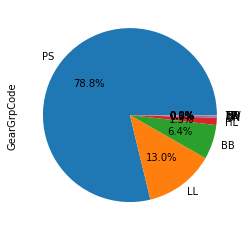

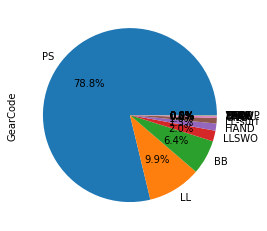

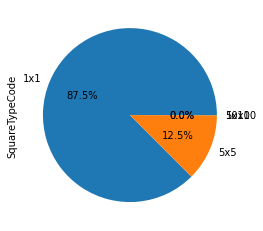

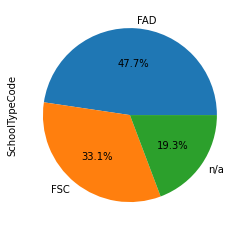

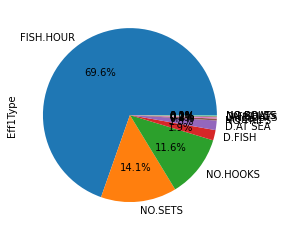

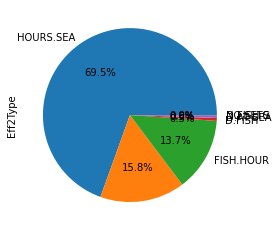

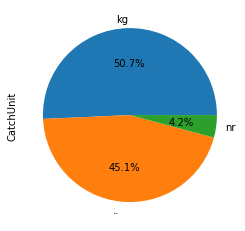

<Figure size 432x288 with 0 Axes>

In [4]:
for var in ['GearGrpCode', 'GearCode', 'SquareTypeCode', 'SchoolTypeCode', 'Eff1Type', 
            'Eff2Type', 'CatchUnit']:
    df[var].value_counts().plot.pie(autopct='%.1f%%')
    plt.show()
    plt.clf()

Legend for gear code:
<br/><br/>
PS: Purse seine

LL: Longline

BB: Baiboat

LLSWO: Longline, targetting SWO (used by Italy)

HAND: Handline

LL-surf: Longline, surface (used by Italy)

GILL: Gillnet, drift net

UNCL: Unclassified, gears not reported

TRAW: Trawl

LLJAP: Longline, japanese (Spain)

TROL: Trolling

SPOR: Sport, recreational fisheries (mostly rod and reel)

TRAWP: Trawl, mid-water pelagic trawl (= MWT)

HS: Haul seine

PSFS: Purne seine, catching small fish

SURF: Surface fisheries unclassified

In [5]:
for i in df:
    print(df[i].value_counts())

843804    1
973582    1
901997    1
904044    1
916330    1
         ..
849844    1
896927    1
894878    1
898972    1
843748    1
Name: StrataID, Length: 108411, dtype: int64
5478    3216
6835    3036
6065    2998
5854    2978
6761    2924
        ... 
7112       1
8056       1
6229       1
8058       1
6232       1
Name: DSetID, Length: 365, dtype: int64
021ES06    21755
008FR04    14464
076CW01     9527
027GH03     7521
027GH04     5989
028PA02     5624
065CV99     5608
197SV01     5188
196GT01     5112
053SN04     4548
003BR00     3496
134BZ99     2974
005TW00     2839
012JP00     2267
021ES03     2070
105GN01     1537
019PT01     1132
118CN00      866
050CI01      794
050CI04      760
111VC00      740
028PA05      572
013KR00      518
113NA00      416
134BZ00      287
053SN01      189
061SH00      175
165PH00      172
053SN02      159
193VU00      136
020ZA00      131
029VE00      104
027GH00       85
134CI00       76
134TT00       73
050CI00       72
053SN03       56
134UY00    

0.00        57548
1.00          104
2.00           61
3.00           50
4.00           42
            ...  
792.87          1
1406.00         1
15000.00        1
1356.00         1
358.00          1
Name: WAH, Length: 635, dtype: int64
0.00        57715
1.00           89
2.00           67
3.00           66
4.00           50
            ...  
23062.93        1
1800.00         1
13200.00        1
18.15           1
51250.00        1
Name: DOL, Length: 579, dtype: int64
0.000000       59315
1.000000          32
2.000000           9
22.000000          5
73.000000          4
               ...  
92.000000          1
121.000000         1
220.364477         1
27.000000          1
2007.000000        1
Name: BIL, Length: 105, dtype: int64
0.000000       59414
1.000000          17
67.000000          2
101.000000         2
84.000000          2
65.000000          2
2.000000           2
115.000000         2
102.000000         1
594.000000         1
336.000000         1
664.000000         1
94.000000 

### Exploring effort and gears in each dataset

In [6]:
sank = df.groupby(['SquareTypeCode', 'GearCode', 'Eff1Type', 'Eff2Type']).size().reset_index(name='counts')

sank2 = df.groupby(['GearGrpCode', 'Eff1Type', 'Eff2Type']).agg({'Eff1': ['count', 'min', 'max', 'median'], 
                                                  'Eff2': ['min', 'max', 'median']})

pd.set_option('display.max_rows', 70)
print(sank)

   SquareTypeCode GearCode   Eff1Type   Eff2Type  counts
0           10x10       LL   NO.HOOKS     D.FISH      23
1           10x10       PS     -none-                  1
2           10x10       PS     D.FISH                 18
3             1x1       BB     -none-                 14
4             1x1       BB   D.AT SEA                403
5             1x1       BB     D.FISH                385
6             1x1       BB   D.FISH.G                 25
7             1x1       BB  FISH.HOUR   D.AT SEA     128
8             1x1       BB  FISH.HOUR  HOURS.SEA    2577
9             1x1       BB  LINE.DAYS                162
10            1x1       BB   NO.POLES                 31
11            1x1       BB    NO.SETS  FISH.HOUR    3226
12            1x1     GILL   NO.BOATS                 60
13            1x1     GILL   NO.TRIPS                140
14            1x1     HAND     -none-                 13
15            1x1     HAND   D.AT SEA               1253
16            1x1     HAND     

We prioritize some types of data, excluding others, concerning:

(1) square type: use only squares < 5°, i.e. only 1x1 and 5x5 squares, excluding 5x10 and 10x10;

(2) fishing gear: use only bait-boat, longline and purse seine (BB, LL and PS), excluding minor gears like gillnets, trolling, trawling, sport fishing, handline and other unclassified gears;

(3) effort type: use only fishing-time-related effort types, like fishing days (D.FISH) and fishing hours (FISH.HOUR) for BB and PS gears; and only number of hooks (NO.HOOKS) for LL gears.

The number of datasets that meet these criteria is 103,375, from a total of 108,411, i.e. 95.35% of all datasets available are kept.

(*) Each dataset has a single SquareTypeCode, a single Gear Type and a single Effort Type.


### Gridding and plotting fishing effort

In [7]:
### Grid 1x1 to plot
Lon = np.arange(-46, 13, 1)
Lat = np.arange(-31, 16, 1)

In [103]:
### Selection as descripted above
df = df[(df['SquareTypeCode']=='1x1') | (df['SquareTypeCode']=='5x5')]
df = df[(df['GearGrpCode']=='LL') | (df['GearGrpCode']=='BB') | (df['GearGrpCode']=='PS')]
df = df[(df['Eff1Type']=='FISH.HOUR') | (df['Eff1Type']=='D.FISH') | (df['Eff1Type']=='NO.HOOKS') | (df['Eff2Type']=='FISH.HOUR')]

year = df['YearC'].unique()

C_h, C_k = np.empty((len(Lon), len(Lat))), np.empty((len(Lon), len(Lat)))
C_h[:], C_k[:] = 0, 0  # array to fill with values


for y in year:                  # Treat each year, then each dataset
    df_y = df[df['YearC']==y]
    dsets = df_y['DSetID'].unique()
    #print('>>>>', y, len(dsets))
    for di, d in enumerate(dsets):
        df_d = df_y[df_y['DSetID']==d]  # until here, we are selecting a single dataset
        #print(di+1, df_d['GearCode'].unique()[0], df_d['SquareTypeCode'].unique()[0], df_d['Eff1Type'].unique()[0], df_d['Eff2Type'].unique()[0])
        #print(df_d.shape)
        df_h1 = df_d[(df_d['Eff1Type']=='FISH.HOUR')]  # Assign dataframes with one effort type each
        df_h2 = df_d[(df_d['Eff2Type']=='FISH.HOUR')]
        df_h3 = df_d[(df_d['Eff1Type']=='D.FISH')]
        df_k = df_d[(df_d['Eff1Type']=='NO.HOOKS')]
        #print(df_h1.shape, df_h2.shape, df_h3.shape, df_k.shape)
        sum_h1 = df_h1.groupby(['Lon', 'Lat'], as_index=False)['Eff1'].sum()  # Sum of all effort in Lat Lon
        sum_h2 = df_h2.groupby(['Lon', 'Lat'], as_index=False)['Eff2'].sum()
        sum_h3 = df_h3.groupby(['Lon', 'Lat'], as_index=False)['Eff1'].sum()
        sum_k = df_k.groupby(['Lon', 'Lat'], as_index=False)['Eff1'].sum()
        #if di == 3:
         #   print(sum_h1)
        
        for i, lo in enumerate(Lon):         # Iterate over grid 
            for j, la in enumerate(Lat):
                eff_h1_b = sum_h1[sum_h1['Lon']==lo+.5]
                eff_h1 = eff_h1_b[eff_h1_b['Lat']==la+.5]
                eff_h2_b = sum_h2[sum_h2['Lon']==lo+.5]    # Locate in each Effort Dataframe the iterated LatLon
                eff_h2 = eff_h2_b[eff_h2_b['Lat']==la+.5]
                eff_h3_b = sum_h3[sum_h3['Lon']==lo+.5]
                eff_h3 = eff_h3_b[eff_h3_b['Lat']==la+.5]
                eff_k_b = sum_k[sum_k['Lon']==lo+.5]
                eff_k = eff_k_b[eff_k_b['Lat']==la+.5]
                #if ((di == 3) and (lo==-20) and (la==10)):
                #    print(lo, la, eff_h1)
                
                try:
                    if df_d['SquareTypeCode'].unique()[0] == '5x5':
                        C_k[i-2:i+3, j-2:j+3] += eff_k.iat[0,2]    # If data is 5x5, distribute effort over 25 1x1 LatLon cells
                    else:
                        C_k[i,j] += eff_k.iat[0,2]
                except IndexError:
                    pass

                eff_h1 = eff_h1.copy()
                eff_h2 = eff_h2.copy()
                eff_h3 = eff_h3.copy()
                
                if eff_h1.empty:
                    eff_h1 = pd.DataFrame([[0, 0, 0]])      # For hours efforts, the sum requires no NaNs
                if eff_h2.empty:
                    eff_h2 = pd.DataFrame([[0, 0, 0]])
                if eff_h3.empty:
                    eff_h3 = pd.DataFrame([[0, 0, 0]])
                
                try:
                    if df_d['SquareTypeCode'].unique()[0] == '5x5':
                        C_h[i-2:i+3, j-2:j+3] += (eff_h1.iat[0,2] + eff_h2.iat[0,2] + eff_h3.iat[0,2]*24)
                    else:
                        C_h[i,j] += (eff_h1.iat[0,2] + eff_h2.iat[0,2] + eff_h3.iat[0,2]*24)  # Days fishing multiplied by 24
                except IndexError:
                    pass
            
                '''if ((la == -28) and (lo==-43)):
                    print(lo, la, eff_k.iat[0,2])
                    break
            if lo == -42:
                break'''
    
C_h[C_h == 0] = np.nan    # Replace all zeros by NaNs, so they stay white in the map
C_k[C_k == 0] = np.nan
#sank3 = df.groupby(['SquareTypeCode', 'GearCode', 'Eff1Type', 'Eff2Type']).size().reset_index(name='counts')
#print(sank3)

>>>> 2012 34
1 LL 5x5 NO.HOOKS 
2 LL 5x5 NO.HOOKS 
3 LL 5x5 NO.HOOKS 
4 BB 1x1 FISH.HOUR HOURS.SEA
5 PS 1x1 FISH.HOUR HOURS.SEA
6 LL 5x5 NO.HOOKS 
7 LL 5x5 NO.HOOKS 
8 LL-surf 5x5 D.FISH 
9 LLSWO 1x1 NO.HOOKS 
10 LLSWO 5x5 NO.HOOKS 
11 BB 1x1 FISH.HOUR HOURS.SEA
12 PS 1x1 FISH.HOUR HOURS.SEA
13 LL 5x5 NO.HOOKS 
14 BB 1x1 NO.SETS FISH.HOUR
15 PS 1x1 NO.SETS FISH.HOUR
16 PS 1x1 NO.SETS FISH.HOUR
17 PS 1x1 FISH.HOUR HOURS.SEA
18 PS 1x1 D.FISH 
19 LL 5x5 D.FISH 
20 BB 1x1 FISH.HOUR HOURS.SEA
21 PS 1x1 FISH.HOUR HOURS.SEA
22 PS 1x1 FISH.HOUR HOURS.SEA
23 PS 1x1 FISH.HOUR HOURS.SEA
24 LL 5x5 NO.HOOKS 
25 LL 5x5 NO.HOOKS 
26 LL 5x5 NO.HOOKS 
27 PS 5x5 D.FISH 
28 PS 5x5 D.FISH 
29 LL 5x5 NO.HOOKS D.FISH
30 LL 5x5 NO.HOOKS D.FISH
31 LL 5x5 NO.HOOKS D.FISH
32 LL 5x5 NO.HOOKS D.FISH
33 LL 5x5 NO.HOOKS 
34 PS 1x1 FISH.HOUR HOURS.SEA
>>>> 2013 39
1 BB 1x1 D.FISH 
2 LL 5x5 NO.HOOKS 
3 LL 5x5 NO.HOOKS 
4 BB 1x1 FISH.HOUR HOURS.SEA
5 PS 1x1 FISH.HOUR HOURS.SEA
6 LL 5x5 NO.HOOKS 
7 LL 5x5 NO.HOOKS 
8 L

### Fishing effort in fishing hours, PS and BB

Text(0.5, 1.0, 'Fishing effort, PS and BB, ICCAT T2CE 2012-2019')

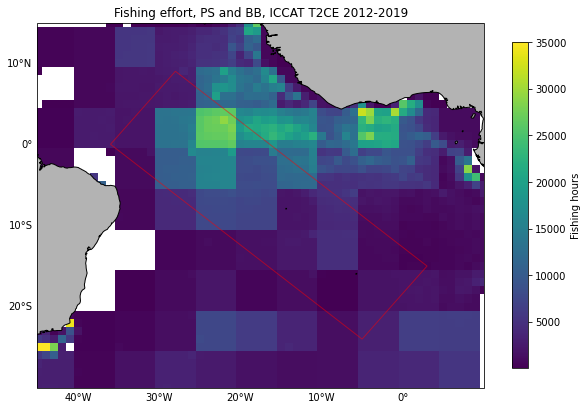

In [124]:
proj = ccrs.PlateCarree()
fig, ax = plt.subplots(1, 1, figsize=(10,10), subplot_kw=dict(projection=proj))

gl = ax.gridlines(alpha=0, draw_labels=True)
gl.top_labels = False
gl.right_labels = False

ax.set_extent([-45, 10, -30, 15], crs=proj)
cm = ax.pcolormesh(Lon, Lat, C_h.T, vmax=35000)
ax.add_feature(LAND)
poly_verts = [(-36,0), (-28,9), (3,-15), (-5,-24)]  # SOMAR polygon
patch_somar = mpatches.Polygon(poly_verts, ec='r', fc='None', alpha=.5)
ax.add_patch(patch_somar)
cb = plt.colorbar(cm, ax=ax, shrink=0.6)
cb.set_label('Fishing hours')
ax.set_title('Fishing effort, PS and BB, ICCAT T2CE 2012-2019')

### Fishing effort in number of hooks, LL

Text(0.5, 1.0, 'Fishing effort, LL, ICCAT T2CE 2012-2019')

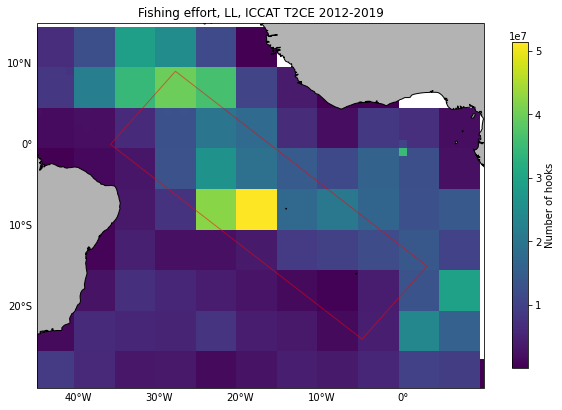

In [130]:
plt.close()
proj = ccrs.PlateCarree()
fig, ax = plt.subplots(1, 1, figsize=(10,10), subplot_kw=dict(projection=proj))

gl = ax.gridlines(alpha=0, draw_labels=True)
gl.top_labels = False
gl.right_labels = False

ax.set_extent([-45, 10, -30, 15], crs=proj)
cm = ax.pcolormesh(Lon, Lat, C_k.T)#, vmax=35000)
ax.add_feature(LAND)
poly_verts = [(-36,0), (-28,9), (3,-15), (-5,-24)]  # SOMAR polygon
patch_somar = mpatches.Polygon(poly_verts, ec='r', fc='None', alpha=.5)
ax.add_patch(patch_somar)
cb = plt.colorbar(cm, ax=ax, shrink=0.6)
cb.set_label('Number of hooks')
ax.set_title('Fishing effort, LL, ICCAT T2CE 2012-2019')

In [105]:
### Save gridded effort into CSV files
np.savetxt('Eff_hours_iccat_2012-19.csv', C_h, delimiter=',')
np.savetxt('Eff_hooks_iccat_2012-19.csv', C_k, delimiter=',')

### A polygon for fishing effort hotspot

Similar to fishing effort distribution exhibited at Global Fishing Watch (GFW) database (also 2012-2019), tropical area east to Ascension Island (5-10° S, 25-15° W) seems to be the major hotspot of fishing effort, especially linked to longliners. At the same time, purse seiners and baitboats seem to concentrate fishing effort more northwards, notably east to Sao Pedro e Sao Paulo Archipelago (0-5° N, 25-20° W). GFW data on purse seiners corroborate this fishing effort hotspot.